In [1]:
import gym
import MCTSnet
import copy
import torch
from importlib import reload
from IPython import display
import time
import PIL
import copy
import marshal
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Testing environment

In [2]:
env = gym.make("SokobanEnc-v0")

In [3]:
len(env.solution)

288

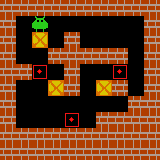

In [4]:
env.render()

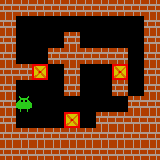

In [5]:
test = []
n_env = copy.deepcopy(env)
for k in reversed(n_env.solution):
    display.clear_output(wait=True)
    res = n_env.step(k)
    display.display(n_env.render())
    time.sleep(0.05)
    test.append(marshal.dumps(res[0]))

In [6]:
len(list(set(test)))

257

# Testing the four neural networks

In [7]:
e = MCTSnet.models.embedding.Epsilon()

In [8]:
state = torch.Tensor(res[0]).to(device)
state.reshape((-1,4,10,10)).shape

torch.Size([1, 4, 10, 10])

In [9]:
embed = e.forward(state.reshape((-1, 4, 10, 10)))

In [10]:
reward = torch.tensor([res[1]], requires_grad=True).to(device)
action = torch.tensor([3.], requires_grad=True).to(device)

In [11]:
b = MCTSnet.models.backup.BetaMLP()

In [12]:
h_s = b(embed, embed, reward.reshape((-1, 1)), action.reshape((-1, 1)))

In [13]:
r = MCTSnet.models.readout.Rho()

In [14]:
r(h_s)

tensor([[0.1291, 0.1250, 0.0890, 0.1322, 0.1395, 0.1286, 0.1460, 0.1106]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [15]:
pi = MCTSnet.models.policy.Pi()
actions = pi(torch.cat((h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s), dim=0).reshape(-1, 9, 128))

In [16]:
actions

tensor([[0.1240, 0.1235, 0.1330, 0.1255, 0.1292, 0.1177, 0.1177, 0.1295]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [17]:
torch.argmax(actions)

tensor(2, device='cuda:0')

In [18]:
state.shape

torch.Size([4, 10, 10])

# Testing the full MCTSnet

In [2]:
m_net = MCTSnet.models.MCTSnet.MCTSnet(b, e, pi, r)
m_net.env = env
m_net.reset_tree(state.reshape((-1, 4, 10, 10)))
prediction = m_net(state.reshape((-1, 4, 10, 10)).to(device))

NameError: name 'b' is not defined

In [20]:
prediction

tensor([[0.1417, 0.1251, 0.1192, 0.1213, 0.1205, 0.1088, 0.1313, 0.1321]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [21]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(m_net.parameters(), lr=0.0001)

### Checking that gradients are computed (is the model differentiable ?)

In [22]:
optimizer.zero_grad()
loss = criterion(prediction, torch.tensor([[1.,0.,0.,0.,0.,0.,0.,0.]]).to(device))
loss.backward()

In [23]:
m_net.backup.fc1.weight.grad

tensor([[-1.3825e-04, -3.3288e-04,  0.0000e+00,  ..., -3.1039e-04,
          3.1080e-04, -1.0484e-02],
        [-4.9653e-05, -9.3596e-05,  0.0000e+00,  ..., -5.5446e-05,
          1.0298e-04, -3.8395e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        ...,
        [ 2.9465e-06,  6.5254e-06,  0.0000e+00,  ...,  4.0941e-06,
         -4.6379e-06,  1.3914e-04],
        [ 2.5059e-04,  5.4204e-04,  0.0000e+00,  ...,  3.8780e-04,
         -4.6067e-04,  1.6059e-02],
        [ 4.6379e-04,  8.2963e-04,  0.0000e+00,  ...,  5.6997e-04,
         -7.0156e-04,  1.9398e-02]], device='cuda:0')

In [24]:
m_net.embedding.input.weight.grad

tensor([[[[ 5.5346e-06, -1.1842e-05,  6.5757e-06],
          [-2.8254e-05, -5.7331e-05,  2.0448e-07],
          [-1.9496e-05, -3.5733e-05,  1.0429e-05]],

         [[-4.6562e-07, -1.9081e-06,  4.0307e-06],
          [-3.6391e-06,  4.2549e-06,  1.2776e-06],
          [ 1.0281e-05, -3.3777e-06, -8.7429e-06]],

         [[-7.2266e-06, -1.5701e-07,  6.2290e-06],
          [-2.1490e-06,  1.3885e-06,  5.7727e-07],
          [-6.2708e-06, -2.2712e-06, -8.5498e-06]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]],


        [[[-2.3142e-05, -2.6199e-05, -1.5284e-05],
          [-3.1806e-06,  1.5894e-06, -5.9759e-06],
          [-1.4218e-05, -4.2831e-06, -5.8098e-06]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-5.7305e-06, -4.3887e-06,  0.0000e+00],
          [-1.2954e-08, -3.8651e-06,  0.0000e+00]],

         [[-1.6341e-06, -1.2954e-08, -4.4458e-06],
          [ 0.000

as "expected" the policy doesn't learn and may require additionnal work

In [25]:
m_net.policy.piL.fc1.weight.grad

In [26]:
m_net.readout.fc1.weight.grad

tensor([[-0.0030, -0.0085, -0.0000,  ..., -0.0000, -0.0125, -0.0108],
        [ 0.0004,  0.0012,  0.0000,  ...,  0.0000,  0.0018,  0.0016],
        [ 0.0004,  0.0012,  0.0000,  ...,  0.0000,  0.0017,  0.0015],
        ...,
        [ 0.0004,  0.0011,  0.0000,  ...,  0.0000,  0.0016,  0.0014],
        [ 0.0005,  0.0013,  0.0000,  ...,  0.0000,  0.0019,  0.0017],
        [ 0.0005,  0.0013,  0.0000,  ...,  0.0000,  0.0019,  0.0017]],
       device='cuda:0')

In [27]:
m_net.state_dict

<bound method Module.state_dict of MCTSnet(
  (backup): BetaMLP(
    (fc1): Linear(in_features=258, out_features=128, bias=True)
  )
  (embedding): Epsilon(
    (input): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (final): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (out): Linear(in_features=3200, out_features=128, bias=True)
  )
  (policy): Pi(
    (piL): PiLogits(
      (fc1): Linear(in_features=128, out_features=8, bias=True)
    )
    (piPL): PiPriorLogits(
      (input): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (res1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (res2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (final): Conv2d(32,

# Trainer

In [28]:
reload(MCTSnet.trainer)
reload(MCTSnet)
sokoban = MCTSnet.MCTSnetSokoban((4, 10, 10), n_embeddings=128, n_actions=4, n_simulations=10)

In [29]:
# sokoban.train(500)

# Attempt at Mouse game

Here we attempt to train the model to imitate a very basic MCTS. More precisely the net must guess the expectation of each action based on the explored graph.

In [41]:
reload(MCTSnet.memory.tree)
reload(MCTSnet.memory)
reload(MCTSnet.trainer)
reload(MCTSnet.models.readout)
reload(MCTSnet.models.backup)
reload(MCTSnet.models.embedding)
reload(MCTSnet.models.MCTSnet)
reload(MCTSnet.mouse.game)
reload(MCTSnet.mouse.solver)
env = MCTSnet.mouse.game.EnvironmentExploring()

bleu +10, jaune -10

In [3]:
state = env.reset()

In [4]:
state.shape

(2, 10, 10)

In [5]:
mnet = MCTSnet.trainer.MCTSnetMouse(n_simulations=15)

In [39]:
# mnet.build_training_set(1000, 100)

In [6]:
mnet.load_training_set("data/mouse_1000_100")

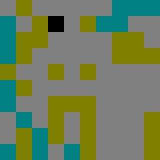

10.0

In [25]:
mnet.play_solution(20, max_steps=100)

In [7]:
mnet.train(10, 40, offset=0)  # 19h07

[1,    99] mean loss: 1.449
[1,   199] mean loss: 1.422
[1,   299] mean loss: 1.393
[1,   399] mean loss: 1.373
[1,   499] mean loss: 1.430
[1,   599] mean loss: 1.400
[1,   699] mean loss: 1.380
[1,   799] mean loss: 1.431
[1,   899] mean loss: 1.406
[1,   999] mean loss: 1.407
[2,    99] mean loss: 1.376
[2,   199] mean loss: 1.423
[2,   299] mean loss: 1.405
[2,   399] mean loss: 1.396
[2,   499] mean loss: 1.375
[2,   599] mean loss: 1.413
[2,   699] mean loss: 1.395
[2,   799] mean loss: 1.388
[2,   899] mean loss: 1.399
[2,   999] mean loss: 1.403
[3,    99] mean loss: 1.369
[3,   199] mean loss: 1.394
[3,   299] mean loss: 1.392
[3,   399] mean loss: 1.406
[3,   499] mean loss: 1.406
[3,   599] mean loss: 1.386
[3,   699] mean loss: 1.366
[3,   799] mean loss: 1.416
[3,   899] mean loss: 1.409
[3,   999] mean loss: 1.374
[4,    99] mean loss: 1.361
[4,   199] mean loss: 1.391
[4,   299] mean loss: 1.393
[4,   399] mean loss: 1.383
[4,   499] mean loss: 1.362
[4,   599] mean loss

[29,   599] mean loss: 1.313
[29,   699] mean loss: 1.381
[29,   799] mean loss: 1.346
[29,   899] mean loss: 1.337
[29,   999] mean loss: 1.338
[30,    99] mean loss: 1.323
[30,   199] mean loss: 1.302
[30,   299] mean loss: 1.313
[30,   399] mean loss: 1.291
[30,   499] mean loss: 1.363
[30,   599] mean loss: 1.294
[30,   699] mean loss: 1.297
[30,   799] mean loss: 1.275
[30,   899] mean loss: 1.338
[30,   999] mean loss: 1.356
[31,    99] mean loss: 1.286
[31,   199] mean loss: 1.288
[31,   299] mean loss: 1.302
[31,   399] mean loss: 1.263
[31,   499] mean loss: 1.305
[31,   599] mean loss: 1.282
[31,   699] mean loss: 1.348
[31,   799] mean loss: 1.358
[31,   899] mean loss: 1.301
[31,   999] mean loss: 1.361
[32,    99] mean loss: 1.276
[32,   199] mean loss: 1.310
[32,   299] mean loss: 1.332
[32,   399] mean loss: 1.308
[32,   499] mean loss: 1.345
[32,   599] mean loss: 1.295
[32,   699] mean loss: 1.321
[32,   799] mean loss: 1.308
[32,   899] mean loss: 1.290
[32,   999] me

KeyboardInterrupt: 

In [8]:
mnet.save_weights("mnet_10_40_0")

In [42]:
mnet2 = MCTSnet.trainer.MCTSnetMouse(n_simulations=15)

In [43]:
mnet2.load_weights("mnet_10_40_0")

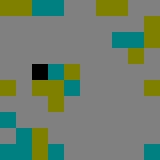

-2.0

In [48]:
mnet2.play(3, max_steps=100)

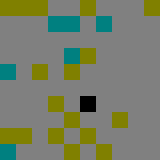

40.0

In [46]:
mnet2.play_solution(2, max_steps=100)